<a href="https://colab.research.google.com/github/shaanbarca/datascience_portfolio/blob/main/final_indonesian_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 15.8MB/s 


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

#from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)



In [ ]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE =1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving out.csv to out.csv


In [ ]:
df = pd.read_csv(r'out.csv',sep=',', error_bad_lines=False, engine='python')


In [ ]:
df.head(5)

,Tweet,negative
0,disaat semua cowok berusaha melacak perhatian ...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1


In [ ]:
print("Dataset size:", len(df))

Dataset size: 13169


mapping data for visualization

In [ ]:
decode_map = {1: "NEGATIVE", 0: "NEUTRAL", -1:"POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.negative = df.negative.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

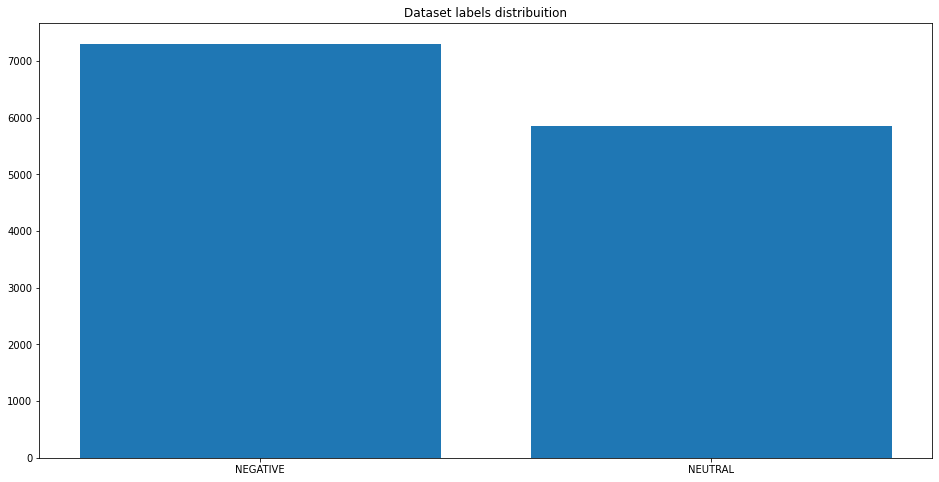

In [ ]:
target_cnt = Counter(df.negative)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

We want to viszualize the data set to show the distribution of our data. Most of the tweets are neutral. While the datasets are not imbalanced, this distributon may affect our model's accuracy

Preprocess data




In [ ]:


#from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#create stemmer
#factory = StemmerFactory()
#stemmers = factory.create_stemmer()


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
important_words = ['janganlah','kasus','kurang','lagian','masalah','masalahnya','manalagi','mempersoalkan','mempertanyakan','mereka','bukan']

In [ ]:
stop_words = set(stopwords.words('indonesian')).difference(important_words)  #for some reason stopwords are not removed i.e ini, dan 

In [ ]:
stop_words.remove("tidak")


In [ ]:
stop_words.remove("enggak")

In [ ]:
stop_words.remove("berlebihan")

In [ ]:
stop_words.remove("bermacam")

In [ ]:
stop_words.remove('bermacam-macam')

In [ ]:
print(stop_words)

{'ditunjuknya', 'ia', 'caranya', 'berakhirnya', 'bagaimanapun', 'sudahkah', 'tanpa', 'ternyata', 'seketika', 'terutama', 'sedikitnya', 'menanya', 'dijelaskan', 'atas', 'berapalah', 'katakanlah', 'lebih', 'mengakhiri', 'per', 'sebanyak', 'tentu', 'benar', 'beginikah', 'bukanlah', 'seberapa', 'kembali', 'bolehlah', 'semuanya', 'mengira', 'empat', 'setengah', 'perlu', 'berapakah', 'bagaikan', 'nanti', 'inginkan', 'sesegera', 'berikutnya', 'bapak', 'sekalian', 'sesekali', 'akhir', 'kamu', 'menanyakan', 'berkali-kali', 'apaan', 'antaranya', 'bersiap', 'pun', 'kemungkinannya', 'saja', 'siapakah', 'bung', 'awal', 'mengingat', 'mempergunakan', 'mengungkapkan', 'tidakkah', 'ataukah', 'seenaknya', 'bahkan', 'aku', 'asal', 'tandas', 'berikut', 'bagaimana', 'sejenak', 'terdiri', 'jadi', 'sebabnya', 'ditanya', 'keinginan', 'menantikan', 'tak', 'tiap', 'siap', 'paling', 'diibaratkannya', 'justru', 'semakin', 'toh', 'sebesar', 'mengenai', 'tanyanya', 'dipergunakan', 'berkehendak', 'dimulai', 'kesampa

In [ ]:
stop_words.remove('jangan')

In [ ]:
print(stop_words)

{'ditunjuknya', 'ia', 'caranya', 'berakhirnya', 'bagaimanapun', 'sudahkah', 'tanpa', 'ternyata', 'seketika', 'terutama', 'sedikitnya', 'menanya', 'dijelaskan', 'atas', 'berapalah', 'katakanlah', 'lebih', 'mengakhiri', 'per', 'sebanyak', 'tentu', 'benar', 'beginikah', 'bukanlah', 'seberapa', 'kembali', 'bolehlah', 'semuanya', 'mengira', 'empat', 'setengah', 'perlu', 'berapakah', 'bagaikan', 'nanti', 'inginkan', 'sesegera', 'berikutnya', 'bapak', 'sekalian', 'sesekali', 'akhir', 'kamu', 'menanyakan', 'berkali-kali', 'apaan', 'antaranya', 'bersiap', 'pun', 'kemungkinannya', 'saja', 'siapakah', 'bung', 'awal', 'mengingat', 'mempergunakan', 'mengungkapkan', 'tidakkah', 'ataukah', 'seenaknya', 'bahkan', 'aku', 'asal', 'tandas', 'berikut', 'bagaimana', 'sejenak', 'terdiri', 'jadi', 'sebabnya', 'ditanya', 'keinginan', 'menantikan', 'tak', 'tiap', 'siap', 'paling', 'diibaratkannya', 'justru', 'semakin', 'toh', 'sebesar', 'mengenai', 'tanyanya', 'dipergunakan', 'berkehendak', 'dimulai', 'kesampa

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmers.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.Tweet = df.Tweet.apply(lambda x: preprocess(x))

In [ ]:
df.head()

,Tweet,negative
0,disaat cowok berusaha melacak perhatian gue lo...,NEGATIVE
1,rt user user telat ngasih tau elu edan sarap g...,NEGATIVE
2,41 kadang berfikir percaya tuhan jatuh berkali...,NEUTRAL
3,user user n nku tau matamu sipit diliat,NEUTRAL
4,user user kaum cebong kapir udah keliatan dong...,NEGATIVE


As we can see, stopwords, links, special symbols have been removed. This helps our process to tokenize

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 10535
TEST size: 2634


# WORD2VEC

In [ ]:
documents = [_text.split() for _text in df_train.Tweet] 

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=5, 
                                            workers=8)
#id_model = gensim.models.Word2Vec.load(path)

In [ ]:
df_train.head()

,Tweet,negative
12017,xf0 x9f x93 x8c himmler pimpinan devisi ss bes...,NEUTRAL
3315,user iya anjir dah,NEGATIVE
6454,user adatuh temen sekelas sma cakep imut sombo...,NEUTRAL
12776,user user user user mongomong ospek ospek disu...,NEUTRAL
9055,bajingan line,NEGATIVE


In [ ]:
w2v_model.build_vocab(documents)

2021-02-18 02:23:35,538 : INFO : collecting all words and their counts
2021-02-18 02:23:35,539 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-18 02:23:35,577 : INFO : PROGRESS: at sentence #10000, processed 141484 words, keeping 23822 word types
2021-02-18 02:23:35,581 : INFO : collected 24554 word types from a corpus of 148973 raw words and 10535 sentences
2021-02-18 02:23:35,582 : INFO : Loading a fresh vocabulary
2021-02-18 02:23:35,596 : INFO : effective_min_count=5 retains 4039 unique words (16% of original 24554, drops 20515)
2021-02-18 02:23:35,597 : INFO : effective_min_count=5 leaves 118702 word corpus (79% of original 148973, drops 30271)
2021-02-18 02:23:35,612 : INFO : deleting the raw counts dictionary of 24554 items
2021-02-18 02:23:35,613 : INFO : sample=0.001 downsamples 36 most-common words
2021-02-18 02:23:35,614 : INFO : downsampling leaves estimated 96939 word corpus (81.7% of prior 118702)
2021-02-18 02:23:35,627 : INFO : estimat

In [ ]:
# words = id_model.wv.vocab.keys()
# vocab_size = len(words)
# print("Vocab size", vocab_size)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 4039


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2021-02-18 02:23:36,434 : INFO : training model with 8 workers on 4039 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2021-02-18 02:23:36,572 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-02-18 02:23:36,618 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-02-18 02:23:36,647 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-02-18 02:23:36,656 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-02-18 02:23:36,659 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-02-18 02:23:36,660 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-02-18 02:23:36,662 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-02-18 02:23:36,670 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-02-18 02:23:36,671 : INFO : EPOCH - 1 : training on 148973 raw words (96929 effective words) took 0.2s, 467052 effecti

(3102524, 4767136)

In [ ]:
#id_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

In [ ]:
w2v_model.wv.most_similar("fpi")
#wv.most_similar()

2021-02-18 02:23:43,562 : INFO : precomputing L2-norms of word weight vectors


[('hti', 0.8844990730285645),
 ('rizieq', 0.8722234964370728),
 ('allahu', 0.860866367816925),
 ('akbar', 0.8552110195159912),
 ('tangkap', 0.8542754650115967),
 ('laporkan', 0.84694504737854),
 ('ditangkap', 0.8404154777526855),
 ('ancam', 0.8356495499610901),
 ('nasdem', 0.8236826658248901),
 ('pernyataan', 0.8220021724700928)]

In [ ]:
w2v_model.save('word2vec.model')

2021-02-18 02:23:43,588 : INFO : saving Word2Vec object under word2vec.model, separately None
2021-02-18 02:23:43,589 : INFO : not storing attribute vectors_norm
2021-02-18 02:23:43,592 : INFO : not storing attribute cum_table
2021-02-18 02:23:43,731 : INFO : saved word2vec.model


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 24555


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Tweet), maxlen=SEQUENCE_LENGTH)

In [ ]:
#label encode
labels = df_train.negative.unique().tolist()

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.negative.tolist())

y_train = encoder.transform(df_train.negative.tolist())
y_test = encoder.transform(df_test.negative.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (10535, 1)
y_test (2634, 1)


In [ ]:
#embedding is to help us cluster the words together 
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(24555, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-02-18 02:23:49,777 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          7366500   
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 7,527,001
Trainable params: 160,501
Non-trainable params: 7,366,500
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
75/75 [==============================] - 72s 913ms/step - loss: 0.5051 - accuracy: 0.7589 - val_loss: 0.4015 - val_accuracy: 0.8283


2021-02-18 02:25:02,190 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 2/8
75/75 [==============================] - 68s 902ms/step - loss: 0.4056 - accuracy: 0.8200 - val_loss: 0.3836 - val_accuracy: 0.8292


2021-02-18 02:26:09,832 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 3/8
75/75 [==============================] - 67s 893ms/step - loss: 0.3890 - accuracy: 0.8274 - val_loss: 0.3671 - val_accuracy: 0.8340


2021-02-18 02:27:16,875 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 4/8
75/75 [==============================] - 68s 901ms/step - loss: 0.3820 - accuracy: 0.8310 - val_loss: 0.3570 - val_accuracy: 0.8406


2021-02-18 02:28:24,390 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 5/8
75/75 [==============================] - 66s 881ms/step - loss: 0.3517 - accuracy: 0.8407 - val_loss: 0.3295 - val_accuracy: 0.8444


2021-02-18 02:29:30,487 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 6/8
75/75 [==============================] - 67s 889ms/step - loss: 0.3435 - accuracy: 0.8515 - val_loss: 0.3232 - val_accuracy: 0.8501


2021-02-18 02:30:37,207 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 7/8
75/75 [==============================] - 68s 910ms/step - loss: 0.3259 - accuracy: 0.8614 - val_loss: 0.3218 - val_accuracy: 0.8548


2021-02-18 02:31:45,445 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


Epoch 8/8
75/75 [==============================] - 67s 895ms/step - loss: 0.3305 - accuracy: 0.8554 - val_loss: 0.3144 - val_accuracy: 0.8672


2021-02-18 02:32:52,615 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


In [ ]:
#evaluate model 
score = model.evaluate(x_test, y_test, batch_size=300)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

9/9 [==============================] - 1s 95ms/step - loss: 0.3275 - accuracy: 0.8569

ACCURACY: 0.8568716645240784
LOSS: 0.3274555206298828


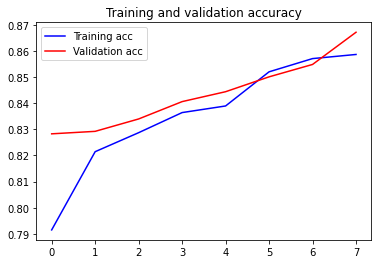

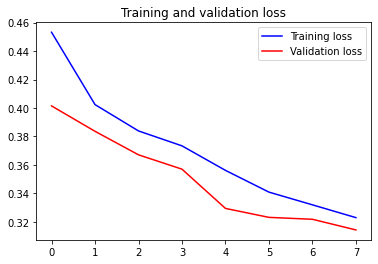

In [ ]:
#ROC vizialization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = NEUTRAL

        return label
    else:
        return NEGATIVE if score < 0.5 else NEUTRAL

In [ ]:
prdef predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("  Sebanyak 2.630 tenaga kesehatan (nakes) di RSD Wisma Atlet Kemayoran, Jakarta Pusat, bakal divaksinasi COVID-19 secara bertahap. Vaksinasi terhadap para tenaga kesehatan ini diprioritaskan karena mereka bersinggungan langsung dengan pasien.Sekitar 2.630 orang ini yang kita prioritaskan, karena mereka langsung bersinggungan dengan para pasien, ujar Pangdam Jaya Mayjen TNI Dudung Abdurachman, kepada wartawan, Rabu (20/1/2021).Pelaksanaan vaksinasi terhadap nakes ini dimulai dari pukul 09.00 WIB sampai 13.00 WIB. Sampai pukul 09.40 WIB, vaksinasi sudah berjalan 25%.Jumlah tenaga kesehatan yang divaksinasi di Wisma Atlet sebanyak 180 dalam setiap hari. Hari ini merupakan hari kedua proses vaksinasi di Wisma Atlet.Jadi saat ini sudah mencapai kurang-lebih sekitar 25% dan ini berlanjut dari jam 09.00 WIB sampai jam 13.00 WIB, kata Dudung.Dudung turut memantau pelaksanaan vaksinasi yang dilaksanakan di Tower 3, Lt 2 Wisma Atlet. Dudung juga terlihat bertanya kepada salah satu nakes yang sudah disuntik vaksin.Kemudian tadi saya tanya langsung kepada nakes yang tadi sudah disuntik, tidak ada dampak apa pun, sehat-sehat saja dan seperti biasa, kata Dudung.Dudung mengatakan pelaksanaan vaksinasi terhadap nakes ini berjalan dengan lancar. Tempat menyimpan vaksin pun sudah sesuai dengan standar di masing-masing puskesmas.Tadi saya lihat secara langsung bahwa, pelaksanaan berjalan lancar. Karena tenaga kerja memang profesional, kemudian vaksin juga disimpan di tempat yang sudah sesuai dengan standar di masing-masing puskesmas, ujar Dudung.Proses vaksinasi itu selanjutnya akan diberikan kepada tenaga profesional lainnya. Tenaga profesional yang akan divaksinasi setelah nakes di antaranya anggota TNI, kepolisian, guru, dan profesional lainnya.Pelaksanaan ini hanya ditujukan kepada tenaga kesehatan terlebih dahulu. Selanjutnya bertahap nanti akan diberikan kepada tenaga profesional dan pelayanan publik, ujar Dudung.Ya seperti anggota TNI, kepolisian kemudian guru dan profesional lainnya, sambung Dudung.")

{'elapsed_time': 0.2916722297668457,
 'label': 'NEUTRAL',
 'score': 0.9979752898216248}

In [ ]:
predict("Jakarta - Aksi Raffi Ahmad yang datang ke pesta ulang tahun Ricardo Gelael usai divaksinasi Corona berbuntut panjang. Ada juga pihak yang menggugat Raffi Ahmad secara perdata karena dianggap melanggar protokol kesehatan.Raffi Ahmad digugat perdata oleh advokat David Tobing di Pengadilan Negeri Depok. David Tobing menilai apa yang dilakukan oleh Raffi Ahmad datang ke pesta usai disuntik vaksin Corona melanggar protokol kesehatan.27 Januari 2021 sidang perdana Raffi Ahmad terkait gugatan tersebut akan digelar. Pihak pengadilan pun sudah mengirimkan surat panggilan kepada Raffi Ahmad.Jadi setelah majelis hakim mengeluarkan penetapan hari sidang, kemudian memerintahkan jurusita pengadilan untuk melakukan panggilan kepada para pihak, jelas Humas Pengadilan Negeri Depok, Nanang Herjunanto melalui sambungan telepon.Panggilan itu sah dan patutnya tiga hari sebelum sidang itu dilaksanakan, imbuhnya.Akan tetapi, Nanang belum bisa memastikan apakah Raffi Ahmad sudah menerima surat panggilan itu atau belum. Saat sidang, para pihak, yakni tergugat dan penggugat dalam hal ini David Tobing sebagai penggugat dan Raffi Ahmad sebagai tergugat diharapkan hadir.David Tobing menggugat Raffi Ahmad ke Pengadilan Negeri Depok pada 15 Januari 2021. Penggugat menduga Raffi Ahmad melanggar aturan protokol kesehatan dalam Peraturan Gubernur Provinsi DKI Jakarta No. 3 tahun 2021 tentang Peraturan Pelaksanaan Peraturan Daerah Nomor 2 Tahun 2020 Tentang Penanggulangan Corona Virus Disease 2019.Termasuk juga tentang Peraturan Daerah Provinsi DKI Jakarta No. 2 tahun 2020 tentang Penanggulangan Corona Virus Disease 2019, dan Undang-Undang No. 6 tahun 2018 tentang Kekarantinaan Kesehatan.Dalam gugatannya, David Tobing ingin Raffi Ahmad tidak boleh meninggalkan rumah selama satu bulan atau 30 hari sejak penyuntikan vaksin Corona kedua diberikan kepadanya.Raffi Ahmad juga harus meminta maaf di tujuh koran, masing-masing setengah halaman, dan tujuh stasiun televisi.")

{'elapsed_time': 0.08864521980285645,
 'label': 'NEUTRAL',
 'score': 0.997605562210083}

In [ ]:
predict("ceboKoq perdata ?? Ahok nd sekalian kah ? Yg punya hajaat ???ng")

{'elapsed_time': 0.0833582878112793,
 'label': 'NEGATIVE',
 'score': 0.08259451389312744}

In [ ]:
predict("saya suka gadis prancis")

{'elapsed_time': 0.08534574508666992,
 'label': 'NEUTRAL',
 'score': 0.8644256591796875}

In [ ]:
predict('saya tidak suka gadis prancis')

{'elapsed_time': 0.08269643783569336,
 'label': 'NEUTRAL',
 'score': 0.9103294014930725}

In [ ]:
predict('Saya seeokor sapi')

{'elapsed_time': 0.08310294151306152,
 'label': 'NEUTRAL',
 'score': 0.5854031443595886}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.negative)
scores = model.predict(x_test, verbose=1, batch_size=300)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

9/9 [==============================] - 1s 100ms/step
CPU times: user 1.05 s, sys: 6.41 ms, total: 1.06 s
Wall time: 1.14 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

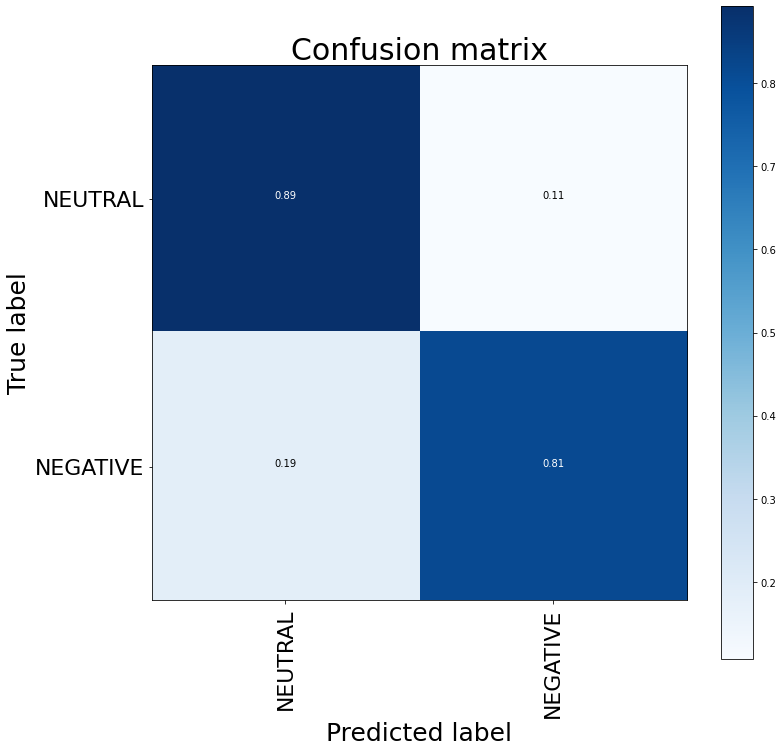

In [ ]:

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.negative.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.89      0.87      1459
     NEUTRAL       0.86      0.81      0.84      1175

    accuracy                           0.86      2634
   macro avg       0.86      0.85      0.85      2634
weighted avg       0.86      0.86      0.86      2634



In [ ]:
print('hello')

hello


In [ ]:
from keras.models import load_model

In [ ]:
model.save('sentiment_model.h5')

In [ ]:
predict('tai')

{'elapsed_time': 0.08764338493347168,
 'label': 'NEGATIVE',
 'score': 0.0715569332242012}